In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import utils
from torchvision.transforms import v2 as transforms
from torchvision import models
from torchvision.models import ResNet18_Weights, ResNet50_Weights
from PIL import Image
import pandas as pd
import os
from matplotlib import pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from torchvision.io.image import decode_jpeg, read_file
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Data Loaders

### Dataset for Returning Image and Class

In [3]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, binary=True):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.binary = binary

       # Add a 'label' column to the DataFrame
        if self.binary:
            self.data['label'] = self.data['real_age'].apply(lambda age: 0 if age < 25 else 1)
            self.classes = self.data['label'].unique().tolist()
        else:
            self.data['label'] = self.data['real_age']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['file_name'])+'_face.jpg'
        label = row['label']

        # Load image
        #image = Image.open(img_path).convert('RGB')  # Load RGB
        image = decode_jpeg(read_file(img_path), device="cpu").to('cuda')
        image = image.float() / image.max() # 255.0 # try normalising by max value in image
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

### Transformations for Data Augmentation and Normalisation

In [4]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8,1.0)),
    transforms.GaussianBlur(kernel_size=3.0, sigma=(0.1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Create Dataset from CSV

In [5]:
train_csv = 'appa-real-release/cropped_train.csv'
val_csv = 'appa-real-release/cropped_valid.csv'
test_csv = 'appa-real-release/cropped_test.csv'

train_dir = 'appa-real-release/cropped_train'
val_dir = 'appa-real-release/cropped_valid'
test_dir = 'appa-real-release/cropped_test'


# Create datasets
train_dataset = CustomDataset(csv_file=train_csv, image_dir=train_dir, transform=train_transforms, binary=True)
val_dataset = CustomDataset(csv_file=val_csv, image_dir=val_dir, transform=val_transforms, binary=True)
test_dataset = CustomDataset(csv_file=test_csv, image_dir=test_dir, transform=test_transforms, binary=True)

In [6]:
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Val Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

print(f"Classes: {train_dataset.classes}. 0<25yo | 1>=25yo")


Train Dataset Size: 3920
Val Dataset Size: 1438
Test Dataset Size: 1828
Classes: [0, 1]. 0<25yo | 1>=25yo


### Stratification

In [7]:
# Compute class weights
class_counts = train_dataset.data['label'].value_counts()
print(f"Class counts: \n{class_counts}\n")
class_weights = 1.0 / class_counts
print(f"Class weights: \n{class_weights}\n")
sample_weights = train_dataset.data['label'].map(class_weights)
print(f"Sample weights: \n{sample_weights}\n")

# Create sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class counts: 
label
1    2437
0    1483
Name: count, dtype: int64

Class weights: 
label
1    0.000410
0    0.000674
Name: count, dtype: float64

Sample weights: 
0       0.000674
1       0.000674
2       0.000410
3       0.000410
4       0.000674
          ...   
3915    0.000410
3916    0.000410
3917    0.000410
3918    0.000410
3919    0.000674
Name: label, Length: 3920, dtype: float64



### Creating Loaders

In [8]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    sampler=sampler
)
val_loader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False
)

### Display Batches

Images batch shape: torch.Size([128, 3, 224, 224])
Labels batch shape: torch.Size([128])
Image Classes: tensor([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
        0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
Class 1 Images: 69
Class 0 Images: 59


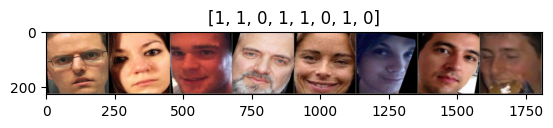

In [9]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = vutils.make_grid(inp)  
    inp = inp.permute(1, 2, 0) 
    
    # Convert mean and std to PyTorch tensors
    mean = torch.tensor([0.485, 0.456, 0.406], device=inp.device)
    std = torch.tensor([0.229, 0.224, 0.225], device=inp.device)
    
    # Normalize the image
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)  # Ensure values are within [0, 1]
    
    # Convert the tensor to a NumPy array for visualization
    inp = inp.cpu().numpy()

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get one batch of data
data_iter = iter(train_loader)  
images, labels = next(data_iter) 
images, labels = images.to(device), labels.to(device)

print(f"Images batch shape: {images.shape}")
print(f"Labels batch shape: {labels.shape}")
print(f"Image Classes: {labels}")

print(f"Class 1 Images: {torch.sum(labels)}")
print(f"Class 0 Images: {len(labels) - torch.sum(labels)}")

n = 8

# Make a grid from batch
out = images[:n]  # Take the first 'n' images

imshow(out, title=[x.item() for x in labels[:n]])


# Model Training

## Using Pytorch pretrained ResNet model - trained on ImageNet

In [10]:
model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features 
print(f"Number of features from pre-trained model {num_features}")

# This is just for logging during training
if num_features == 512:
    resnet_arch = 'ResNet18'
elif num_features ==2048:
    resnet_arch = 'ResNet50'
else:
    resnet_arch = 'other'

Number of features from pre-trained model 512


### Add a fully connected layer
- Freeze weights for existing parameters of pretrained model
    - These dont need retrained since we are doing transfer learning
- Add a fully connected linear layer
    - This maps from the output of the pretrained model (512 for ResNet-18 / 2048 for ResNet-50)
    - To the output we want for our classifier (1 - the probability of being a certain class)
- The weights in this layer will be trained to fit our data

In [11]:
train_on_l4 = False
# Freeze the layers in the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze all residual blocks in the fourth layer
# For resnet-18 that is 2 blocks, for resnet50 that is 3 blocks
if train_on_l4:
    for name, param in model.layer4.named_parameters(): 
        print(name)
        param.requires_grad = True
        train_on_l4 = True
    
# Add a fully connected linear layer which transforms from 512 nodes -> 1 node
# Note that we dont add a sigmoid activation function here because we use nn.BCEWithLogitsLoss(), which applies sigmoid while calculating loss
model.fc = nn.Linear(num_features, 1)

for param in model.fc.parameters():
    param.requires_grad = True


# This is just to store a string for saving the model after training
print("\nSetup:")
if train_on_l4:
    train_type = 'fc+layer4'
else:
    train_type = 'fc'

print(train_type)
print(resnet_arch)


Setup:
fc
ResNet18


In [12]:
import torch
import torchvision.models as models

# Function to count parameters
def count_parameters(model):
    total_params = 0
    trainable_params = 0
    
    # Count parameters for each layer
    layer_params = {
        'Conv1': sum(p.numel() for p in model.conv1.parameters()),
        'BN1': sum(p.numel() for p in model.bn1.parameters()),
        'Layer1': sum(p.numel() for p in model.layer1.parameters()),
        'Layer2': sum(p.numel() for p in model.layer2.parameters()),
        'Layer3': sum(p.numel() for p in model.layer3.parameters()),
        'Layer4': sum(p.numel() for p in model.layer4.parameters()),
        'FC': sum(p.numel() for p in model.fc.parameters())
    }
    
    # Total parameters
    for name, params in layer_params.items():
        total_params += params
        print(f"{name} Parameters: {params:,}")
    
    print(f"\nTotal Parameters: {total_params:,}")
    return layer_params

# Count parameters
layer_params = count_parameters(model)

print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.parameters() if param.requires_grad==True]):,}")

Conv1 Parameters: 9,408
BN1 Parameters: 128
Layer1 Parameters: 147,968
Layer2 Parameters: 525,568
Layer3 Parameters: 2,099,712
Layer4 Parameters: 8,393,728
FC Parameters: 513

Total Parameters: 11,177,025
Number of Learnable Parameters:  513


In [13]:
def unfreeze_layers(model, i):
    """
    Unfreeze specific layers in the model
    
    Args:
    model (nn.Module): The ResNet model
    start_layer (int): Starting layer to unfreeze (e.g., 4 for layer4)
    end_layer (int): Ending layer to unfreeze
    """
    
    # Unfreeze specified layers
    layers = [model.layer1, model.layer2, model.layer3, model.layer4]
    for param in layers[i].parameters():
        param.requires_grad = True    
    #for i in range(start_layer-1, end_layer):

    print(f"Number of Learnable Parameters:  {sum([param.numel() for param in model.parameters() if param.requires_grad==True]):,}")

### Train and Test functions

In [14]:
def train(model, device, train_loader, optimizer, criterion, epoch, writer, verbose=0):

    model.train()
    epoch_loss = 0 # Keep track of total loss over this epoch
    if verbose:
        print('Train')
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        
        # Forward Pass
        output = model(data)

        # Compute Loss
        # Squeeze output: (32, 1) -> (32,) to match target shape (32,)
        # Convert target to float: Targets are integers 0,1. Loss function expects float
        loss = criterion(output.squeeze(), target.float()) 
        if verbose:
            print(f"Batch {batch_idx}: Loss = {loss:.4f}")
        epoch_loss += loss.item()
        
        # Backwards pass and optimisation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0 and not verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = epoch_loss / len(train_loader)
    if verbose:
        print(f"Avg loss = {epoch_loss:.4f} / {len(train_loader)} = {avg_loss:.4f}")

    writer.add_scalar('Train', epoch_loss / len(train_loader), epoch)

In [15]:
def val(model, device, val_loader, criterion, epoch, writer, verbose=0):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0

    correct_output_class_0 = 0
    correct_output_class_1 = 0
    correct_count_class_0 = 0
    correct_count_class_1 = 0

    incorrect_output_class_0 = 0
    incorrect_output_class_1 = 0
    incorrect_count_class_0 = 0
    incorrect_count_class_1 = 0
    
    if verbose !=0:
        print('Val')
    
    with torch.no_grad():
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Compute loss
            batch_loss = criterion(output.squeeze(), target.float()).item() # calculate the loss for this batch
            
            if verbose == 1:
                print(f"Batch {i}: Loss = {batch_loss:.4f}")
                
            val_loss += batch_loss # keep a sum of all the losse for this batch
            # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

            if verbose ==2:
                for p, t, out in zip(pred, target, output):
                    if p==t:
                        if t==0:
                            correct_output_class_0 += out.item()
                            correct_count_class_0 += 1
                        elif t==1:
                            correct_output_class_1 += out.item()
                            correct_count_class_1 += 1
                    else:
                        if t==0:
                            incorrect_output_class_0 += out.item()
                            incorrect_count_class_0 += 1
                        elif t==1:
                            incorrect_output_class_1 += out.item()
                            incorrect_count_class_1 += 1

    
    if verbose == 2:
        # Print the average confidence (output) of the model for correct classifications of each class
        avg_correct_output_0 = (
            correct_output_class_0 / correct_count_class_0 if correct_count_class_0 > 0 else 0
        )
        avg_correct_output_1 = (
            correct_output_class_1 / correct_count_class_1 if correct_count_class_1 > 0 else 0
        )
        avg_incorrect_output_0 = (
            incorrect_output_class_0 / incorrect_count_class_0 if incorrect_count_class_0 > 0 else 0
        )
        avg_incorrect_output_1 = (
            incorrect_output_class_1 / incorrect_count_class_1 if incorrect_count_class_1 > 0 else 0
        )
        print('\n')
        print(f'Average output for correctly classified class 0: {avg_correct_output_0:.4f}')
        print(f'Average output for incorrectly classified class 0: {avg_incorrect_output_0:.4f}\n')
        
        print(f'Average output for correctly classified class 1: {avg_correct_output_1:.4f}')
        print(f'Average output for incorrectly classified class 1: {avg_incorrect_output_1:.4f}\n')
    
    # Average the val loss over the entire dataset
    avg_loss = val_loss/len(val_loader)
    
    if verbose:
        print(f"Avg loss = {val_loss:.4f} / {len(val_loader)} = {avg_loss:.4f}")
    
    # Print results
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    writer.add_scalars('Val', {
        'Loss': avg_loss,
        'Accuracy': correct / len(val_loader.dataset)
    }, epoch)
    return val_loss

In [16]:
%reload_ext tensorboard

In [17]:
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.1)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)

# optimizer = optim.SGD(model.parameters(), lr=0.001)

now = datetime.now()
log_dir = "./logs/" + now.strftime("%Y%m%d-%H%M%S-") + resnet_arch + "_GradualUnfreeze_"+"/"
writer = SummaryWriter(log_dir=log_dir, comment='Training Logs')

for epoch in range(1, 50 + 1):

    if epoch <= 10:
        # Just train on fc layer
        pass
    elif epoch <= 20:
        # Unfreeze layer4 (train on fc+l4)
        unfreeze_layers(model, 0)
    elif epoch <= 30:
        # Unfreeze layer3 (train on fc+l4+l3)
        unfreeze_layers(model, 1)
    elif epoch <= 40:
        # Unfreeze layer2 (train on fc+l4+l3+l2)
        unfreeze_layers(model, 2)
    elif epoch <= 50:
        # Unfreeze layer1 (train on fc+l4+l3+l2+l1)
        unfreeze_layers(model, 3)
    # Past epoch 50 keep training on all layers
    
    train(model, device, train_loader, optimizer, criterion, epoch, writer)
    val_loss = val(model, device, val_loader, criterion, epoch, writer)
    #scheduler.step(val_loss)

writer.close()

Train Epoch: 1 [0/3920 (0%)]	Loss: 0.708828
Train Epoch: 1 [1280/3920 (32%)]	Loss: 0.702347
Train Epoch: 1 [2560/3920 (65%)]	Loss: 0.701123
Train Epoch: 1 [2400/3920 (97%)]	Loss: 0.689721

Validation set: Average loss: 0.6815, Accuracy: 797/1438 (55%)

Train Epoch: 2 [0/3920 (0%)]	Loss: 0.677109
Train Epoch: 2 [1280/3920 (32%)]	Loss: 0.706632
Train Epoch: 2 [2560/3920 (65%)]	Loss: 0.678353
Train Epoch: 2 [2400/3920 (97%)]	Loss: 0.670120

Validation set: Average loss: 0.7072, Accuracy: 734/1438 (51%)

Train Epoch: 3 [0/3920 (0%)]	Loss: 0.660781
Train Epoch: 3 [1280/3920 (32%)]	Loss: 0.655442
Train Epoch: 3 [2560/3920 (65%)]	Loss: 0.659613
Train Epoch: 3 [2400/3920 (97%)]	Loss: 0.695962

Validation set: Average loss: 0.6781, Accuracy: 809/1438 (56%)

Train Epoch: 4 [0/3920 (0%)]	Loss: 0.694863
Train Epoch: 4 [1280/3920 (32%)]	Loss: 0.712581
Train Epoch: 4 [2560/3920 (65%)]	Loss: 0.684295
Train Epoch: 4 [2400/3920 (97%)]	Loss: 0.688298

Validation set: Average loss: 0.6586, Accuracy: 855/

In [23]:
parameter_version = 'v2'
torch.save(model.state_dict(), "./models/"  + resnet_arch +"_" + train_type + "_" + now.strftime("%Y-%m-%d") + "_" +parameter_version+ ".pth")
print("Saved model to ./models/"  + resnet_arch +"_" +train_type + "_" + now.strftime("%Y-%m-%d") + "_" + parameter_version +".pth")

Saved model to ./models/ResNet18_fc_2025-02-05_v2.pth


In [18]:
%tensorboard --logdir=./logs/ --host localhost --port 7032

# Test Evaluation

In [19]:
def test(model, device, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            # Compute loss
            output = model(data)       
            test_loss += criterion(output.squeeze(), target.float()).item()  # Sum up batch loss
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1
            
            # Update correct count (compare predictions to target)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Average the val loss over the entire dataset
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [20]:
test_loss, test_accuracy = test(model, device, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.5441, Test Accuracy: 73.4683


# Visualise Predictions

In [21]:
def visualize_model(model, num_images=6, show_fails=False):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = model(inputs)
            
            # # Apply sigmoid to logits to get probabilities
            output = torch.sigmoid(output)
            
            # Get predictions by thresholding at 0.5
            pred = (output > 0.5).float()  # Convert probabilities to 0 or 1

            for j in range(inputs.size()[0]):
                # Check if prediction matches the label
                is_misclassified = pred[j].item() != labels[j].item()

                # Skip correctly classified cases if show_fails is True
                if show_fails and not is_misclassified:
                    continue
                    
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {pred[j].item()}. Ground Truth: {labels[j].item()}.')
                print(f'Confidence / Model Output: {output[j].item():.3f}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

0/1 - High confidence, ~0.5 - Low confidence
Confidence / Model Output: 0.435


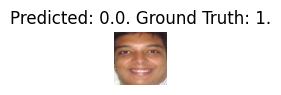

Confidence / Model Output: 0.036


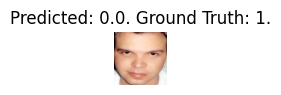

Confidence / Model Output: 0.742


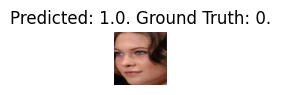

Confidence / Model Output: 0.868


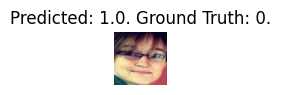

Confidence / Model Output: 0.118


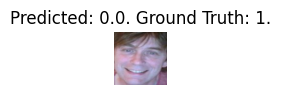

Confidence / Model Output: 0.495


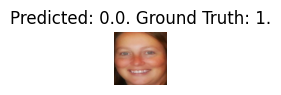

Confidence / Model Output: 0.414


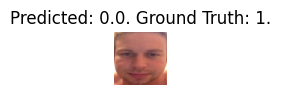

Confidence / Model Output: 0.061


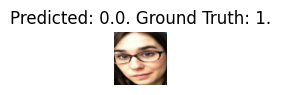

Confidence / Model Output: 0.212


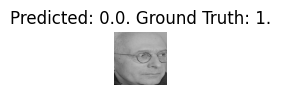

Confidence / Model Output: 0.621


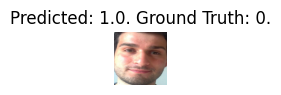

Confidence / Model Output: 0.341


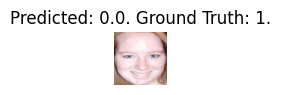

Confidence / Model Output: 0.100


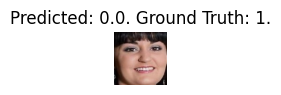

In [22]:
print('0/1 - High confidence, ~0.5 - Low confidence')
print('='*50)
visualize_model(model, num_images=12, show_fails=True)